# EDA
## Import necessary libraries 

In [52]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings
import numpy as np
import requests
from io import StringIO
import nfl_data_py as nfl

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Load the data from digital ocean

In [53]:
# Define the base path and URLs as per your config file
BASE_CDN_PATH = "https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com"
TRACKING_DATA_URL_TEMPLATE = BASE_CDN_PATH + "/raw/tracking_data/tracking_week_{week}.csv"
PLAYS_URL = BASE_CDN_PATH + "/raw/plays.csv"
GAMES_URL = BASE_CDN_PATH + "/raw/games.csv"
PLAYERS_URL = BASE_CDN_PATH + "/raw/players.csv"
COLORS_URL = BASE_CDN_PATH + "/raw/colors.csv"
TACKLES_URL = BASE_CDN_PATH + "/raw/tackles.csv"

# Replace 'week' with the actual week number you want to download
week_number = 1
TRACKING_DATA_URL = TRACKING_DATA_URL_TEMPLATE.format(week=week_number)

# Define a function to download and return a DataFrame
def download_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Assuming the data is in CSV format
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to download data from {url}")
        return None


# Download the data
tracking_data = download_data(TRACKING_DATA_URL)
plays_data = download_data(PLAYS_URL)
players_data = download_data(PLAYERS_URL)
colors_data = download_data(COLORS_URL)
tackles_data = download_data(TACKLES_URL)
games_data = download_data(GAMES_URL) 

In [54]:
print(tracking_data.info())
print(plays_data.info())
print(players_data.info())
print(colors_data.info())
print(tackles_data.info())
print(games_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407439 entries, 0 to 1407438
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   gameId         1407439 non-null  int64  
 1   playId         1407439 non-null  int64  
 2   nflId          1346246 non-null  float64
 3   displayName    1407439 non-null  object 
 4   frameId        1407439 non-null  int64  
 5   time           1407439 non-null  object 
 6   jerseyNumber   1346246 non-null  float64
 7   club           1407439 non-null  object 
 8   playDirection  1407439 non-null  object 
 9   x              1407439 non-null  float64
 10  y              1407439 non-null  float64
 11  s              1407439 non-null  float64
 12  a              1407439 non-null  float64
 13  dis            1407439 non-null  float64
 14  o              1346397 non-null  float64
 15  dir            1346397 non-null  float64
 16  event          130268 non-null   object 
dtypes: float

## Load DATA from pipeline

In [55]:
df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_1_completions_only_run2.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Loop through weeks 2 to 9
for week in range(1, 10):
    # Construct file path for the current week
    file_path = f'/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_{week}_completions_only_run2.csv'
    
    # Read the data
    week_df = pd.read_csv(file_path)
    
    # Remove any unnamed columns
    week_df = week_df.loc[:, ~week_df.columns.str.contains('^Unnamed')]
    
    # Append to the original DataFrame
    df = pd.concat([df, week_df], ignore_index=True)


In [56]:
df.columns

Index(['nflId', 'frechet_distance', 'play_id', 'game_id', 'week_num',
       'displayName', 'position', 'gameId', 'playId', 'passResult',
       'expectedPointsAdded', 'defensiveTeam'],
      dtype='object')

In [57]:
#sanity check
plays_per_game = df.groupby('game_id')['play_id'].nunique()

# Calculating the average number of plays per game
average_plays_per_game = plays_per_game.mean()
average_plays_per_game

41.4921875

20 per team seems reasonable 

In [58]:
# Merge the DataFrames on 'playId' and 'nflId'
frechet_tackles_df = pd.merge(df, tackles_data, left_on=['playId', 'nflId','gameId'], right_on=['playId', 'nflId','gameId'], how='left')

In [59]:
frechet_tackles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29575 entries, 0 to 29574
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                29575 non-null  float64
 1   frechet_distance     29575 non-null  float64
 2   play_id              29575 non-null  int64  
 3   game_id              29575 non-null  int64  
 4   week_num             29575 non-null  int64  
 5   displayName          29575 non-null  object 
 6   position             29575 non-null  object 
 7   gameId               29575 non-null  int64  
 8   playId               29575 non-null  int64  
 9   passResult           29458 non-null  object 
 10  expectedPointsAdded  29575 non-null  float64
 11  defensiveTeam        29575 non-null  object 
 12  tackle               4811 non-null   float64
 13  assist               4811 non-null   float64
 14  forcedFumble         4811 non-null   float64
 15  pff_missedTackle     4811 non-null  

In [60]:
import pandas as pd

# Assuming df is your DataFrame
# Fill NaN values in defensive stats with 0
frechet_tackles_df[['tackle', 'assist', 'forcedFumble']] = frechet_tackles_df[['tackle', 'assist', 'forcedFumble']].fillna(0)

# Selecting non-ID and defensive stats columns
columns_of_interest = ['frechet_distance', 'expectedPointsAdded', 'tackle', 'assist', 'forcedFumble']

# Calculate correlation
correlation_matrix = frechet_tackles_df[columns_of_interest].corr()

print(correlation_matrix)


                     frechet_distance  expectedPointsAdded    tackle  \
frechet_distance             1.000000             0.181870  0.000479   
expectedPointsAdded          0.181870             1.000000  0.025801   
tackle                       0.000479             0.025801  1.000000   
assist                      -0.026442            -0.008502 -0.062759   
forcedFumble                -0.010130            -0.063358  0.091151   

                       assist  forcedFumble  
frechet_distance    -0.026442     -0.010130  
expectedPointsAdded -0.008502     -0.063358  
tackle              -0.062759      0.091151  
assist               1.000000      0.019878  
forcedFumble         0.019878      1.000000  


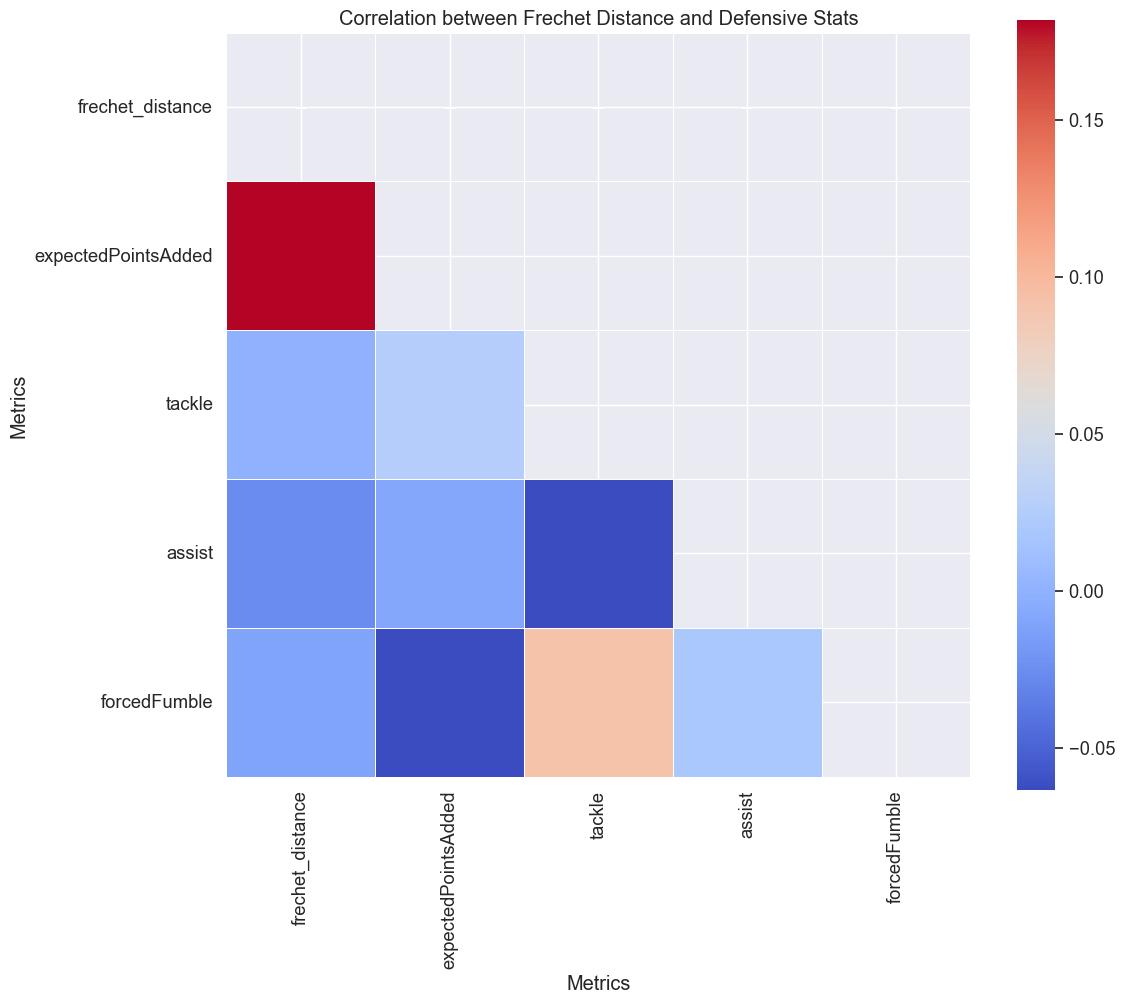

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'frechet_tackles_df' is a predefined DataFrame with relevant data
# Make sure to replace the sample data creation with your actual DataFrame

# Fill NaN values with 0 in the DataFrame
frechet_tackles_df[['tackle', 'assist', 'forcedFumble']] = frechet_tackles_df[['tackle', 'assist', 'forcedFumble']].fillna(0)

# Selecting the columns of interest
columns_of_interest = ['frechet_distance', 'expectedPointsAdded', 'tackle', 'assist', 'forcedFumble']

# Calculate the correlation matrix
correlation_matrix = frechet_tackles_df[columns_of_interest].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Increase the figure size and adjust font scale for better visibility
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)

# Create a heatmap with a mask for the upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)

# Adding titles and labels for clarity
plt.title('Correlation between Frechet Distance and Defensive Stats')
plt.xlabel('Metrics')
plt.ylabel('Metrics')

# Show the plot
plt.show()


High correlation here because the players are traviling farther and farther away from the frechet distance when a secondary player makes a tackle. 

In [62]:
df

,nflId,frechet_distance,play_id,game_id,week_num,displayName,position,gameId,playId,passResult,expectedPointsAdded,defensiveTeam
0,42816.0,5.541076,56,2022090800,1,Troy Hill,CB,2022090800,56,C,0.004420,LA
1,43294.0,2.414401,56,2022090800,1,Jalen Ramsey,CB,2022090800,56,C,0.004420,LA
2,47844.0,1.396304,56,2022090800,1,Taylor Rapp,FS,2022090800,56,C,0.004420,LA
3,48026.0,3.803265,56,2022090800,1,Nick Scott,SS,2022090800,56,C,0.004420,LA
4,52607.0,2.331613,56,2022090800,1,Jordan Fuller,SS,2022090800,56,C,0.004420,LA
...,...,...,...,...,...,...,...,...,...,...,...,...
29570,42361.0,5.445091,3480,2022110700,9,Marcus Peters,CB,2022110700,3480,C,4.241395,BAL
29571,44828.0,17.124201,3480,2022110700,9,Marlon Humphrey,CB,2022110700,3480,C,4.241395,BAL
29572,44999.0,9.354360,3480,2022110700,9,Chuck Clark,SS,2022110700,3480,C,4.241395,BAL
29573,52627.0,15.952410,3480,2022110700,9,Geno Stone,SS,2022110700,3480,C,4.241395,BAL


In [63]:
# Define the years and columns of interest
years = [2022]
columns = ['old_game_id', 'play_id', 'yards_after_catch', 
           'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 
           'comp_yac_epa', 'comp_yac_wpa', 'week']

# Import the play-by-play data
pbp_data = nfl.import_pbp_data(years, columns)

# Filter for weeks 1-9
filtered_pbp_data = pbp_data[pbp_data['week'].between(1, 10)]

# Ensure the data types for merging columns are consistent
filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)
df['gameId'] = df['gameId'].astype(int)

# Import the play_level_frechet data
# You would need to specify how to import this data, as the method is not provided in your query

# Merge the data
data = pd.merge(filtered_pbp_data, df, left_on=['old_game_id', 'play_id'], right_on=['gameId', 'play_id'])


2022 done.
Downcasting floats.


/var/folders/kj/29dyy8nn54v_615jgbd59t7h0000gn/T/ipykernel_26722/3311383526.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)


In [64]:
data.columns

Index(['old_game_id', 'play_id', 'yards_after_catch', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'comp_yac_epa',
       'comp_yac_wpa', 'week', 'season', 'nflverse_game_id', 'possession_team',
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'players_on_play',
       'offense_players', 'defense_players', 'n_offense', 'n_defense',
       'ngs_air_yards', 'time_to_throw', 'was_pressure', 'route',
       'defense_man_zone_type', 'defense_coverage_type', 'nflId',
       'frechet_distance', 'game_id', 'week_num', 'displayName', 'position',
       'gameId', 'playId', 'passResult', 'expectedPointsAdded',
       'defensiveTeam'],
      dtype='object')

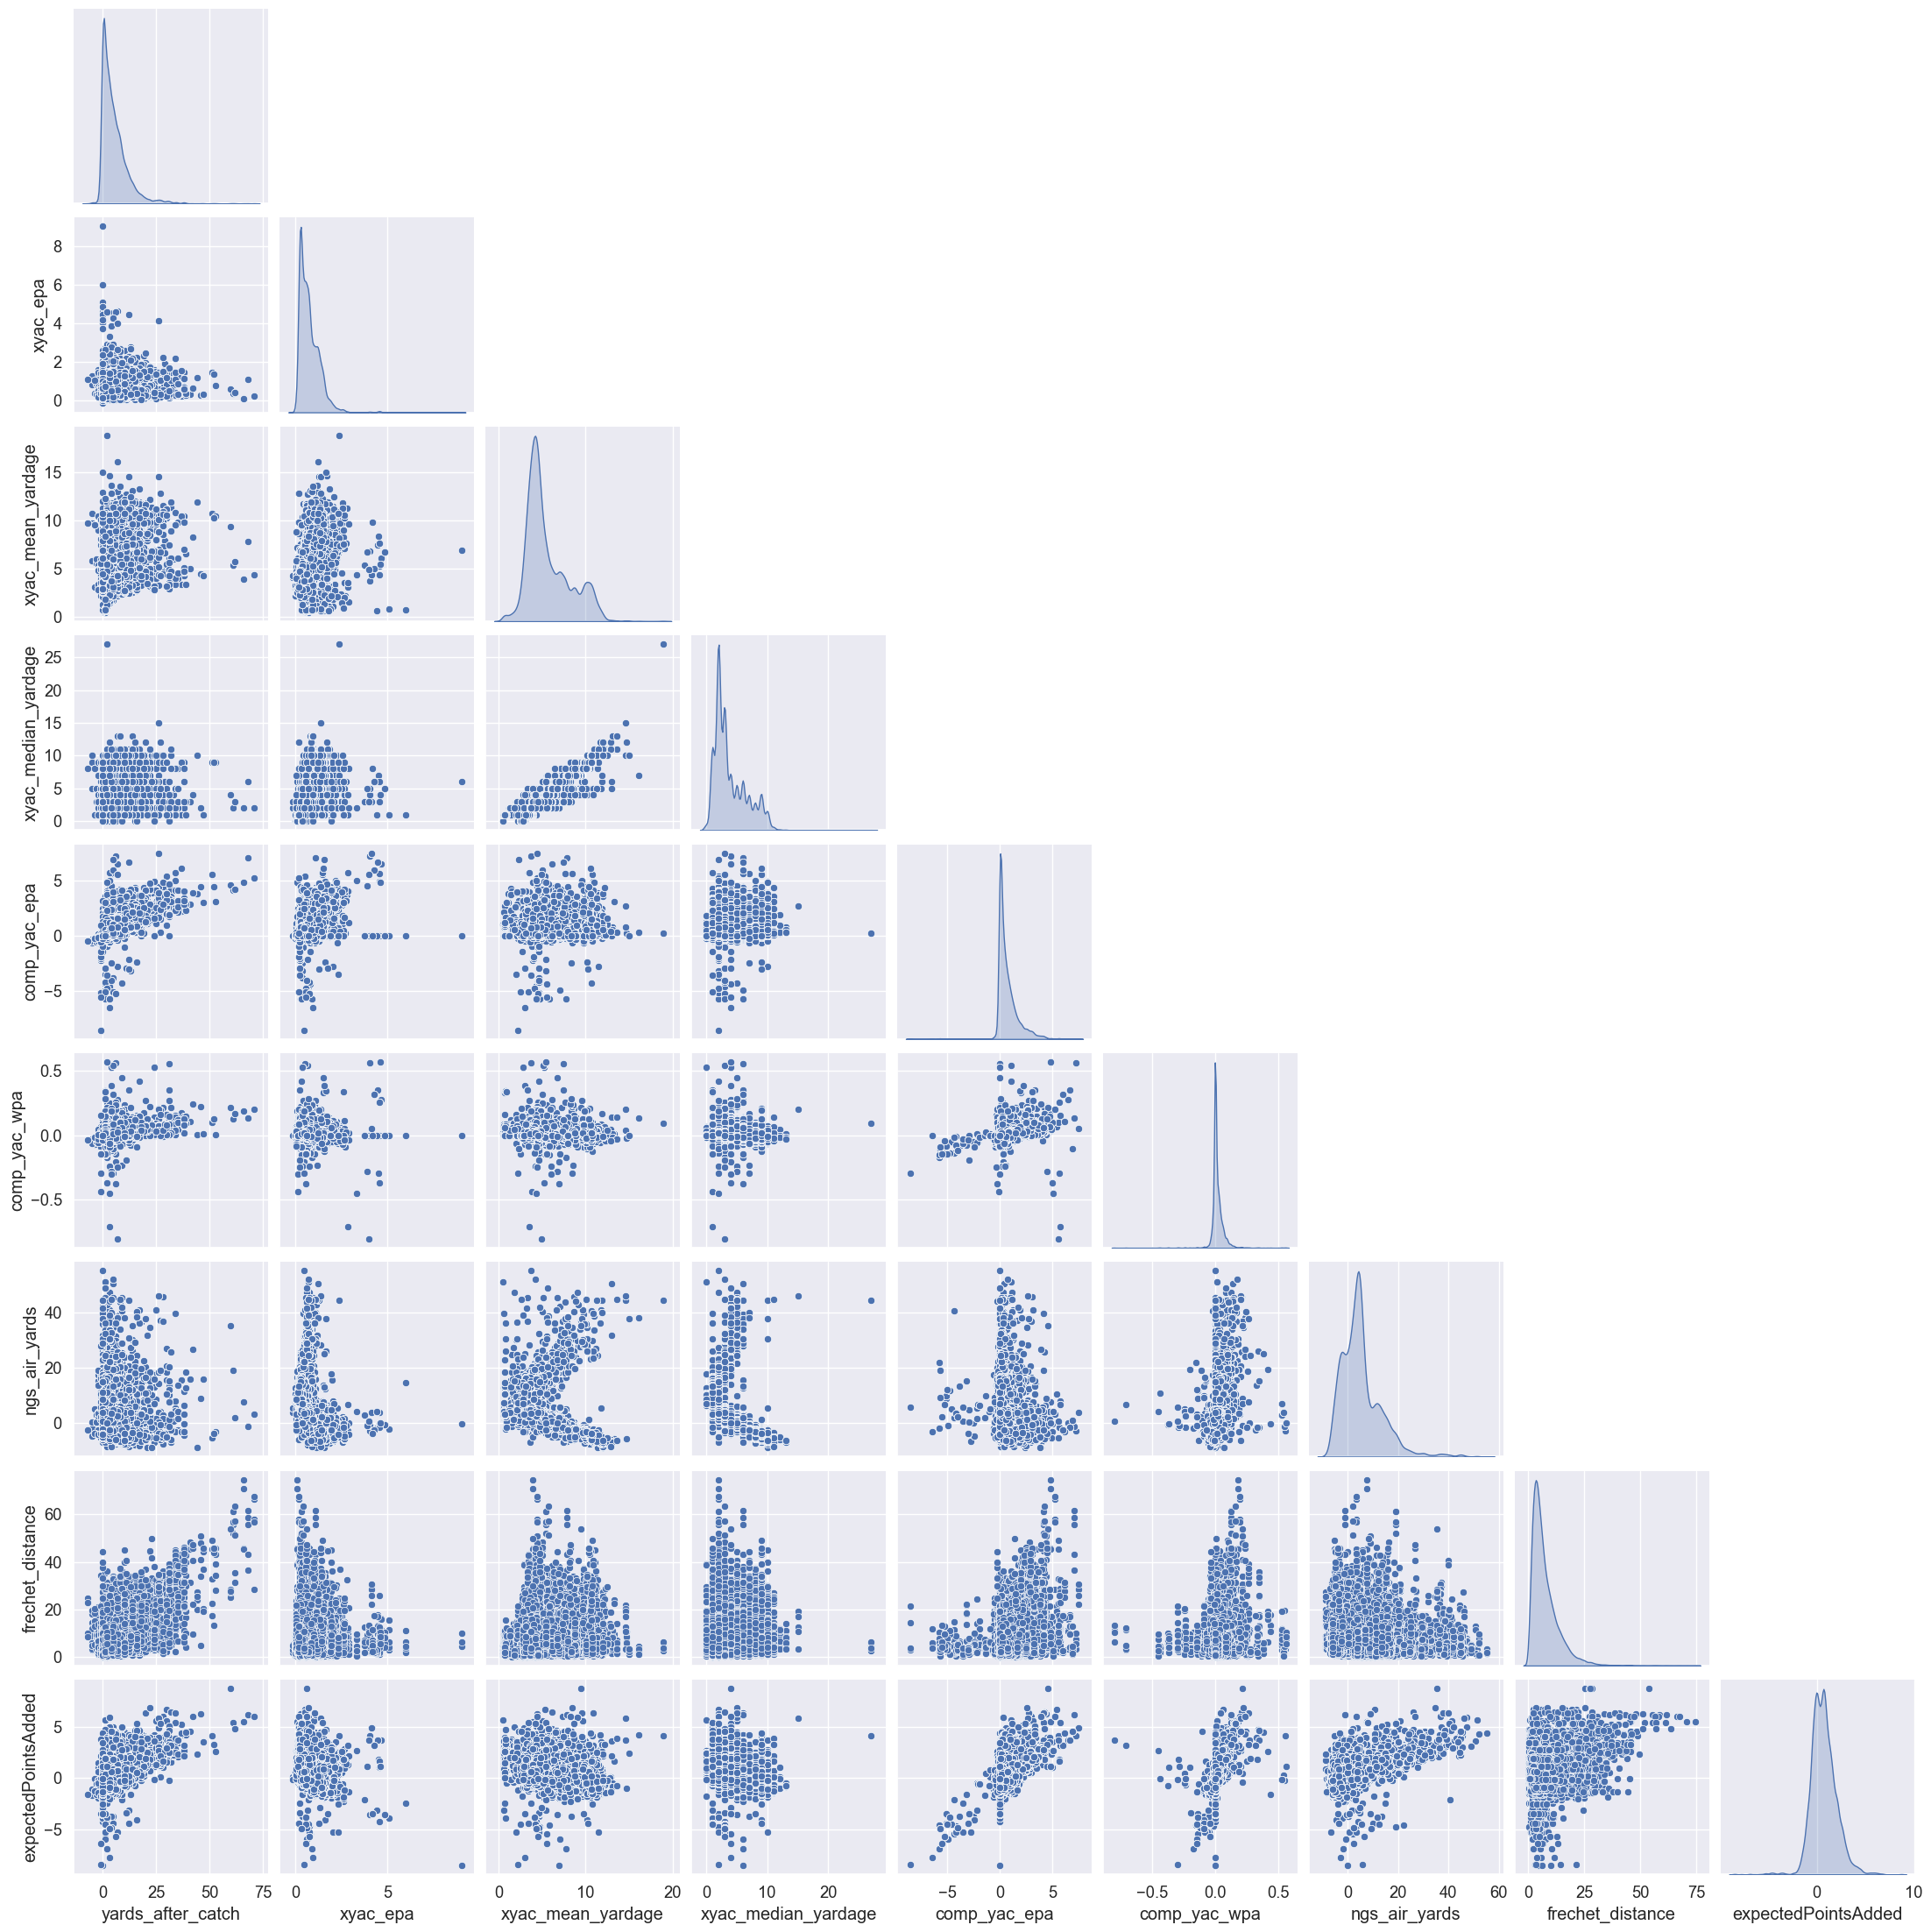

In [112]:
columns = ['yards_after_catch', 'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 
           'comp_yac_epa', 'comp_yac_wpa', 'ngs_air_yards', 'frechet_distance', 
           'position', 'passResult', 'expectedPointsAdded']

# Filtering the DataFrame to include only the selected columns
df_filtered = data[columns]

# Creating the pair plot
sns.pairplot(df_filtered, diag_kind = 'kde', corner=True)

# Displaying the plot
plt.show()

In [65]:
# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
data['yac_diff'] =  data['xyac_mean_yardage'] - data['yards_after_catch']
data['pasta'] = data['yac_diff'] / data['frechet_distance'] #this attributes yac diff to individual players based off 

In [66]:
# Aggregate at the player level to get averages across all plaue
player_level_agg = data.groupby(['nflId','displayName','position','defensiveTeam']).agg(
    total_frechet=('frechet_distance', 'sum'),
    average_frechet = ('frechet_distance', 'mean'),
    average_yac_diff = ('yac_diff', 'mean'),
    total_yac_diff = ('yac_diff','sum'), 
    average_yac = ('yards_after_catch', 'mean'),
    total_yac = ('yards_after_catch','sum'),
    average_comp_yac_epa = ('comp_yac_epa', 'mean'),
    total_comp_yac_epa = ('comp_yac_epa','sum'),
    number_of_plays = ('playId','nunique'),
    number_of_games= ('gameId','nunique'), 
    total_pasta = ('pasta', 'sum'), 
    average_pasta = ('pasta', 'mean')
).reset_index()

In [67]:
# Aggregate at the team level to get averages across all plays per team
team_level_agg_per_play = data.groupby(['defensiveTeam','playId']).agg(
    average_frechet_per_player=('frechet_distance', 'mean'),
    total_frechet_all_player = ('frechet_distance', 'sum'),
    number_in_swarm = ('nflId', 'nunique'), 
    gameId = ('gameId' , 'first'),
    yac_diff = ('yac_diff','first'), 
    yac = ('yards_after_catch','first'),
    comp_yac_epa = ('comp_yac_epa','first'), 
    total_pasta = ('pasta', 'sum'), 
    average_pasta = ('pasta', 'mean')
).reset_index()


In [68]:
team_level_agg_per_play['number_in_swarm'].value_counts()

number_in_swarm
5    3496
4     914
6     693
7      78
8      21
3       8
1       1
9       1
Name: count, dtype: int64

In [69]:
# Filter out plays with only one unique player
team_level_agg_per_play = team_level_agg_per_play[ team_level_agg_per_play['number_in_swarm'] > 1]

In [70]:
team_level_agg_per_play

,defensiveTeam,playId,average_frechet_per_player,total_frechet_all_player,number_in_swarm,gameId,yac_diff,yac,comp_yac_epa,total_pasta,average_pasta
0,ARI,56,3.613681,14.454722,4,2022102000,3.522917,1.0,0.280683,5.917144,1.479286
1,ARI,67,2.447102,9.788406,4,2022110608,3.813271,6.0,0.746822,7.466334,1.866584
2,ARI,96,4.808981,24.044906,5,2022091811,2.702016,2.0,0.169015,3.675002,0.735000
3,ARI,112,7.635420,38.177100,5,2022110608,-6.852213,11.0,3.601726,-4.513076,-0.902615
4,ARI,145,7.093197,28.372788,4,2022102000,-4.258143,9.0,1.755527,-2.702684,-0.675671
...,...,...,...,...,...,...,...,...,...,...,...
5207,WAS,3850,2.058799,12.352796,6,2022101300,0.636805,0.0,0.000000,1.973232,0.328872
5208,WAS,4135,4.151283,24.907697,6,2022102306,-0.063910,6.0,-0.232072,-0.099197,-0.016533
5209,WAS,4286,5.205275,52.052747,5,2022091109,2.468500,1.0,-0.248911,5.742150,0.574215
5210,WAS,4299,6.360433,31.802164,5,2022092508,-0.839116,4.0,0.195296,-0.988830,-0.197766


In [71]:
# Aggregate at the player level to get averages across all plaue
team_level_agg = team_level_agg_per_play.groupby('defensiveTeam').agg(
    total_frechet=('average_frechet_per_player', 'sum'),
    average_frechet = ('average_frechet_per_player', 'mean'),
    average_in_swarm = ('number_in_swarm', 'mean'), 
    average_yac_diff = ('yac_diff', 'mean'),
    total_yac_diff = ('yac_diff','sum'), 
    average_yac = ('yac', 'mean'),
    total_yac = ('yac','mean'),
    average_comp_yac_epa = ('comp_yac_epa', 'mean'),
    total_comp_yac_epa = ('comp_yac_epa','sum'), 
    total_pasta = ('total_pasta','sum'), 
    average_pasta = ('total_pasta', 'mean')
).reset_index()

In [72]:
player_level_agg = player_level_agg[player_level_agg['number_of_plays'] > 20]

In [73]:
player_level_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 322
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nflId                 242 non-null    float64
 1   displayName           242 non-null    object 
 2   position              242 non-null    object 
 3   defensiveTeam         242 non-null    object 
 4   total_frechet         242 non-null    float64
 5   average_frechet       242 non-null    float64
 6   average_yac_diff      242 non-null    float32
 7   total_yac_diff        242 non-null    float32
 8   average_yac           242 non-null    float32
 9   total_yac             242 non-null    float32
 10  average_comp_yac_epa  242 non-null    float32
 11  total_comp_yac_epa    242 non-null    float32
 12  number_of_plays       242 non-null    int64  
 13  number_of_games       242 non-null    int64  
 14  total_pasta           242 non-null    float64
 15  average_pasta         242 no

In [74]:
# Merge the aggregated data with the team colors data
team_df_with_colors = team_level_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')
player_df_with_colors = player_level_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')


In [75]:
team_df_with_colors.columns

Index(['defensiveTeam', 'total_frechet', 'average_frechet', 'average_in_swarm',
       'average_yac_diff', 'total_yac_diff', 'average_yac', 'total_yac',
       'average_comp_yac_epa', 'total_comp_yac_epa', 'total_pasta',
       'average_pasta', 'team_abbr', 'team_name', 'team_id', 'team_nick',
       'team_conf', 'team_division', 'team_color', 'team_color2',
       'team_color3', 'team_color4', 'team_logo_wikipedia', 'team_logo_espn',
       'team_wordmark', 'team_conference_logo', 'team_league_logo'],
      dtype='object')

In [76]:
# Save the DataFrame as a CSV file
team_df_with_colors.to_csv('team_level_filtered_completed_passes.csv', index=False)
player_df_with_colors.to_csv('player_level_filtered_completed_passes.csv', index=False)


In [77]:
player_df_with_colors.columns

Index(['nflId', 'displayName', 'position', 'defensiveTeam', 'total_frechet',
       'average_frechet', 'average_yac_diff', 'total_yac_diff', 'average_yac',
       'total_yac', 'average_comp_yac_epa', 'total_comp_yac_epa',
       'number_of_plays', 'number_of_games', 'total_pasta', 'average_pasta',
       'team_abbr', 'team_name', 'team_id', 'team_nick', 'team_conf',
       'team_division', 'team_color', 'team_color2', 'team_color3',
       'team_color4', 'team_logo_wikipedia', 'team_logo_espn', 'team_wordmark',
       'team_conference_logo', 'team_league_logo'],
      dtype='object')

In [85]:

# Sort by PASTA score and reset the index to keep defensiveTeam as a column
player_totals_scores = player_df_with_colors.sort_values(by='total_pasta', ascending=False).reset_index()

# Add PASTA rank
player_totals_scores['PASTA RANK'] = player_totals_scores['total_pasta'].rank(method='dense', ascending=False)

# Round all numerical columns to one decimal place
player_totals_scores = player_totals_scores.round(1)

# Optional: Drop the original index column if it's still there
if 'index' in player_totals_scores.columns:
    player_totals_scores.drop(columns=['index'], inplace=True)



In [86]:
# Sort by PASTA score and reset the index to keep defensiveTeam as a column
team_pasta_scores = team_df_with_colors.sort_values(by='total_pasta', ascending=False).reset_index()

# Add PASTA rank
team_pasta_scores['PASTA RANK'] = team_pasta_scores['total_pasta'].rank(method='dense', ascending=False)

# Round all numerical columns to one decimal place
team_pasta_scores = team_pasta_scores.round(1)

# Optional: Drop the original index column if it's still there
if 'index' in team_pasta_scores.columns:
    team_pasta_scores.drop(columns=['index'], inplace=True)




In [87]:
player_totals_scores.columns

Index(['nflId', 'displayName', 'position', 'defensiveTeam', 'total_frechet',
       'average_frechet', 'average_yac_diff', 'total_yac_diff', 'average_yac',
       'total_yac', 'average_comp_yac_epa', 'total_comp_yac_epa',
       'number_of_plays', 'number_of_games', 'total_pasta', 'average_pasta',
       'team_abbr', 'team_name', 'team_id', 'team_nick', 'team_conf',
       'team_division', 'team_color', 'team_color2', 'team_color3',
       'team_color4', 'team_logo_wikipedia', 'team_logo_espn', 'team_wordmark',
       'team_conference_logo', 'team_league_logo', 'PASTA RANK'],
      dtype='object')

In [88]:
# Assuming team_pasta_scores is your DataFrame
columns_of_interest = ['PASTA RANK','team_wordmark', 'total_pasta','average_yac_diff', 'average_frechet', 'average_comp_yac_epa', 'average_in_swarm']
team_pasta_rankings = team_pasta_scores[columns_of_interest]


# Assuming team_pasta_scores is your DataFrame
columns_of_interest = ['PASTA RANK','displayName','position','team_wordmark', 'total_pasta','average_yac_diff', 'average_frechet', 'average_comp_yac_epa','number_of_plays']
player_pasta_rankings = player_totals_scores[columns_of_interest]


In [89]:
from IPython.display import display, HTML

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Create a copy of the DataFrame for display
display_df = team_pasta_rankings.copy()

# Apply the image formatter
display_df['team_wordmark'] = display_df['team_wordmark'].map(image_formatter)

# Convert DataFrame to HTML and display
display(HTML(display_df.to_html(escape=False)))


,PASTA RANK,team_wordmark,total_pasta,average_yac_diff,average_frechet,average_comp_yac_epa,average_in_swarm
0,1.0,,784.3,0.9,6.1,0.6,5.3
1,2.0,,639.6,1.3,7.0,0.5,5.0
2,3.0,,627.1,0.3,6.4,0.5,4.8
3,4.0,,605.3,0.6,7.2,0.6,4.9
4,5.0,,564.4,0.8,6.7,0.6,4.8
5,6.0,,558.6,0.7,7.0,0.8,5.0
6,7.0,,526.3,-0.1,7.4,0.7,5.4
7,8.0,,519.5,0.2,7.1,0.5,5.2
8,9.0,,507.1,-0.1,8.1,0.7,4.9
9,10.0,,473.9,0.2,7.8,0.7,5.3


In [90]:
from IPython.display import display, HTML

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Create a copy of the DataFrame for display
display_df = player_pasta_rankings.copy()

# Apply the image formatter
display_df['team_wordmark'] = display_df['team_wordmark'].map(image_formatter)

# Convert DataFrame to HTML and display
display(HTML(display_df.to_html(escape=False)))

,PASTA RANK,displayName,position,team_wordmark,total_pasta,average_yac_diff,average_frechet,average_comp_yac_epa,number_of_plays
0,1.0,Roger McCreary,CB,,175.2,0.9,5.9,0.6,205
1,2.0,Jaylinn Hawkins,FS,,175.1,0.8,5.1,0.5,204
2,3.0,Darius Slay,CB,,157.6,0.6,6.2,0.8,143
3,4.0,Kareem Jackson,SS,,154.1,1.4,6.1,0.5,177
4,5.0,Kristian Fulton,CB,,148.4,0.9,6.4,0.6,182
5,6.0,Jamel Dean,CB,,144.8,0.7,6.6,0.6,181
6,7.0,Jevon Holland,FS,,142.0,0.1,7.3,0.7,204
7,8.0,Chuck Clark,SS,,139.8,0.2,6.7,0.7,204
8,9.0,Kevin Byard,FS,,131.1,0.9,6.3,0.6,205
9,10.0,Vonn Bell,SS,,125.9,0.4,6.3,0.5,141


In [91]:
# Assuming 'player_pasta_rankings' is a predefined DataFrame with relevant data
# Sort the DataFrame based on 'PASTA RANK'
player_pasta_rankings = player_pasta_rankings.sort_values('PASTA RANK', ascending=True)

# We'll now group by 'position' and take the top 5 from each position
top_players_by_position = player_pasta_rankings.groupby('position').head(5)

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Apply the image formatter
top_players_by_position.loc[:, 'team_wordmark'] = top_players_by_position['team_wordmark'].apply(image_formatter)

# Display the DataFrame with styles
styles = [
    dict(selector="th", props=[("font-size", "110%"), ("text-align", "center")]),
    dict(selector="td", props=[("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

html = (top_players_by_position.style
    .background_gradient(subset=['average_frechet'], cmap='coolwarm')
    .background_gradient(subset=['average_yac_diff'], cmap='coolwarm')
    .set_table_styles(styles)
    .set_caption("Top 5 Players at Each Position Ranked by PASTA RANK")
    .to_html(escape=False)) # using to_html instead of render

# Display styled DataFrame side by side for each position
display(HTML(html))



,PASTA RANK,displayName,position,team_wordmark,total_pasta,average_yac_diff,average_frechet,average_comp_yac_epa,number_of_plays
0,1.000000,Roger McCreary,CB,,175.200000,0.900000,5.900000,0.600000,205
1,2.000000,Jaylinn Hawkins,FS,,175.100000,0.800000,5.100000,0.500000,204
2,3.000000,Darius Slay,CB,,157.600000,0.600000,6.200000,0.800000,143
3,4.000000,Kareem Jackson,SS,,154.100000,1.400000,6.100000,0.500000,177
4,5.000000,Kristian Fulton,CB,,148.400000,0.900000,6.400000,0.600000,182
5,6.000000,Jamel Dean,CB,,144.800000,0.700000,6.600000,0.600000,181
6,7.000000,Jevon Holland,FS,,142.000000,0.100000,7.300000,0.700000,204
7,8.000000,Chuck Clark,SS,,139.800000,0.200000,6.700000,0.700000,204
8,9.000000,Kevin Byard,FS,,131.100000,0.900000,6.300000,0.600000,205
9,10.000000,Vonn Bell,SS,,125.900000,0.400000,6.300000,0.500000,141


In [92]:
team_pasta_scores.columns

Index(['defensiveTeam', 'total_frechet', 'average_frechet', 'average_in_swarm',
       'average_yac_diff', 'total_yac_diff', 'average_yac', 'total_yac',
       'average_comp_yac_epa', 'total_comp_yac_epa', 'total_pasta',
       'average_pasta', 'team_abbr', 'team_name', 'team_id', 'team_nick',
       'team_conf', 'team_division', 'team_color', 'team_color2',
       'team_color3', 'team_color4', 'team_logo_wikipedia', 'team_logo_espn',
       'team_wordmark', 'team_conference_logo', 'team_league_logo',
       'PASTA RANK'],
      dtype='object')

need tp adjust and modify everything below here 

In [101]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(team_pasta_scores['total_comp_yac_epa'], team_pasta_scores['total_pasta'])


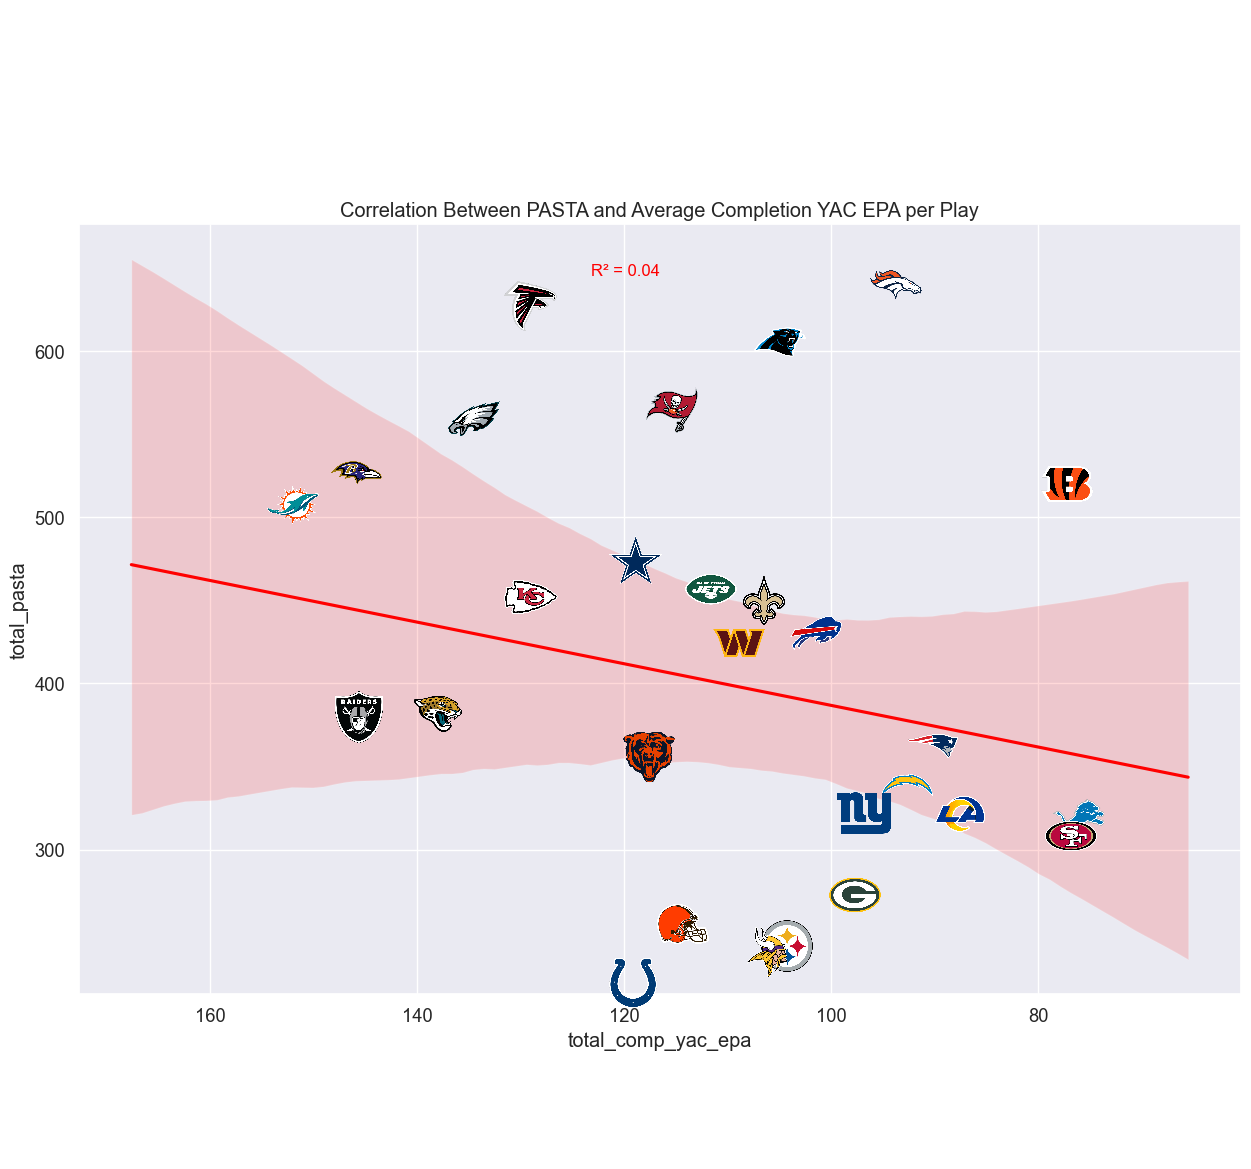

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Create the scatter plot with a regression line
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(x='total_comp_yac_epa', y='total_pasta', data=team_pasta_scores, ax=ax, scatter=False, color='red')


# Plot each team with its logo
for index, row in team_pasta_scores.iterrows():
    # Load team logo from URL
    response = requests.get(row['team_logo_espn'])
    img = Image.open(BytesIO(response.content))

    # Convert image to a format suitable for matplotlib
    imagebox = OffsetImage(img, zoom=0.08)
    ab = AnnotationBbox(imagebox, (row['total_comp_yac_epa'], row['total_pasta']), frameon=False)
    ax.add_artist(ab)

# Set labels and title
ax.set_xlabel('total_comp_yac_epa')
ax.set_ylabel('total_pasta')
ax.set_title('Correlation Between PASTA and Average Completion YAC EPA per Play')
ax.text(0.5, 0.95, f'R\u00b2 = {r_value**2:.2f}', ha='right', va='top', transform=ax.transAxes, color='red', fontsize=12)
plt.gca().invert_xaxis()  # Invert the y-axis

plt.show()


In [104]:
player_totals_scores

,nflId,displayName,position,defensiveTeam,total_frechet,average_frechet,average_yac_diff,total_yac_diff,average_yac,total_yac,...,team_color,team_color2,team_color3,team_color4,team_logo_wikipedia,team_logo_espn,team_wordmark,team_conference_logo,team_league_logo,PASTA RANK
0,54500.0,Roger McCreary,CB,TEN,1337.1,5.9,0.9,192.000000,4.8,1060.0,...,#002244,#4B92DB,#c60c30,#a5acaf,https://github.com/nflverse/nflfastR-data/raw/...,https://a.espncdn.com/i/teamlogos/nfl/500/ten.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,1.0
1,52542.0,Jaylinn Hawkins,FS,ATL,1174.1,5.1,0.8,179.399994,4.5,988.0,...,#A71930,#000000,#a5acaf,#a30d2d,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,2.0
2,39984.0,Darius Slay,CB,PHI,1018.8,6.2,0.6,90.599998,5.2,816.0,...,#004C54,#A5ACAF,#acc0c6,#000000,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/phi.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,3.0
3,35459.0,Kareem Jackson,SS,DEN,1246.5,6.1,1.4,263.600006,4.4,860.0,...,#002244,#FB4F14,#00234c,#ff5200,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/den.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,4.0
4,52469.0,Kristian Fulton,CB,TEN,1293.6,6.4,0.9,170.000000,4.9,946.0,...,#002244,#4B92DB,#c60c30,#a5acaf,https://github.com/nflverse/nflfastR-data/raw/...,https://a.espncdn.com/i/teamlogos/nfl/500/ten.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,54550.0,Marcus Jones,CB,NE,172.3,7.5,-1.1,-25.700001,7.0,160.0,...,#002244,#C60C30,#b0b7bc,#001532,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/ne.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,238.0
238,54778.0,Jaylon Jones,CB,CHI,418.9,7.0,-0.6,-36.900002,6.2,360.0,...,#0B162A,#C83803,#0b162a,#c83803,https://upload.wikimedia.org/wikipedia/commons...,https://a.espncdn.com/i/teamlogos/nfl/500/chi.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,239.0
239,54584.0,Jalyn Armour-Davis,CB,BAL,267.0,9.9,-1.9,-50.200001,7.3,191.0,...,#241773,#9E7C0C,#9e7c0c,#c60c30,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,240.0
240,47829.0,Greedy Williams,CB,CLE,207.3,7.7,-0.0,-1.200000,6.3,170.0,...,#FF3C00,#311D00,#a5acaf,#d32f1e,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/cle.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,241.0


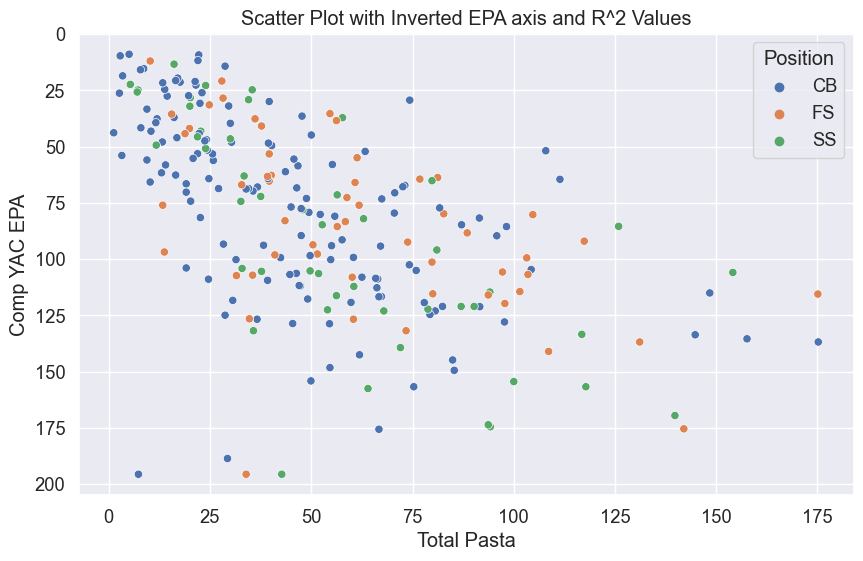

{'CB': -1.1224323748025116, 'FS': -0.3822680195713286, 'SS': -0.8432471657214551, 'All': -0.7973556713048311}


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for plotting
from sklearn.metrics import r2_score

# Assuming player_totals_scores is your DataFrame and has the required columns.

# Calculate R^2 values
r2_values = {}
positions = player_totals_scores['position'].unique()
for position in positions:
    subset = player_totals_scores[player_totals_scores['position'] == position]
    r2_values[position] = r2_score(subset['total_pasta'], subset['total_comp_yac_epa'])

# R^2 for all positions
r2_values['All'] = r2_score(player_totals_scores['total_pasta'], player_totals_scores['total_comp_yac_epa'])

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=player_totals_scores, x='total_pasta', y='total_comp_yac_epa', hue='position')

plt.xlabel('Total Pasta')
plt.ylabel('Comp YAC EPA')  # Update this label to reflect the correct metric
plt.title('Scatter Plot with Inverted EPA axis and R^2 Values')
plt.legend(title='Position')
plt.gca().invert_yaxis()  # Invert the y-axis

plt.grid(True)
plt.show()


# Print R^2 values
print(r2_values)


